<a href="https://colab.research.google.com/github/jinoh5/cognitive_modeling/blob/main/Full_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/Clean Code - cognitive modeling

/content/drive/MyDrive/Colab Notebooks/Clean Code - cognitive modeling


**Cognitive Modeling on head-fixed mice performing a dynamic reward learning task**
- Built by Jin Oh (yu.jin.oh84@gmail.com) 

- Input: Choice datasets of mice performing a dynamic two-armed bandit task 
  - In this code, I have not added the mice choice dataset for privacy issue. If needed, please contact the author.
- Output: 
  - Qualitative diagnostics of average mice behavior 
  - Qualitative diagnostics of agents' behavior 
  - Quantitative comparison between synthetic agents (cross-validated normalized log likliehood scores) 

[Supplementary Information]
- Generative agents:
  vanillaQ_agent, optimisticQ_agent, generalized_local_matching_law_agent, forgettingQ_agent, differential_forgettingQ_agent, habitsRL_agent, basic_ideal_observer_agent, ideal_observer_1_back_perseveration_agent, ideal_observer_habits_agent, marginal_value_theorem_agent
- Qualitative diagnostics:
  - Trial history generalized linear models (choice perseveration, reward seeking, main effect of reward) 
  - Choice Bias 
  - Bout distribution 
  - Learning curve 
- Modeling fitting software: Pystan 


In [2]:
pip install pystan==2.19.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import necessary packages 
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure 
import statsmodels.api as sm
from scipy import stats

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Import experiment design, agents, and fit functions
from twoarmedbandittask import *
from generative_agents import *
from fit_functions import *
# Import other functions 
from load_mousedata import *
from create_input_format import *
from qualitative_diagnostics_functions import *
from visualization_helper import *
from run_trials import * 
from fit_multiple_times import * 
from log_likelihood import *

In [4]:
# Import mice choice datasets 
behavior_filenames = ['mousedata_AL038.csv','mousedata_AL039.csv','mousedata_AL040.csv',
                      'mousedata_AL041.csv','mousedata_AL042.csv','mousedata_AL049.csv',
                      'mousedata_AL050.csv','mousedata_AL053.csv','mousedata_AL054.csv',
                      'mousedata_AL055.csv','mousedata_AL056.csv','mousedata_AL058.csv', 
                      'mousedata_AL059.csv']

***Qualitative diagnostics of average mice behavior with data visualization***


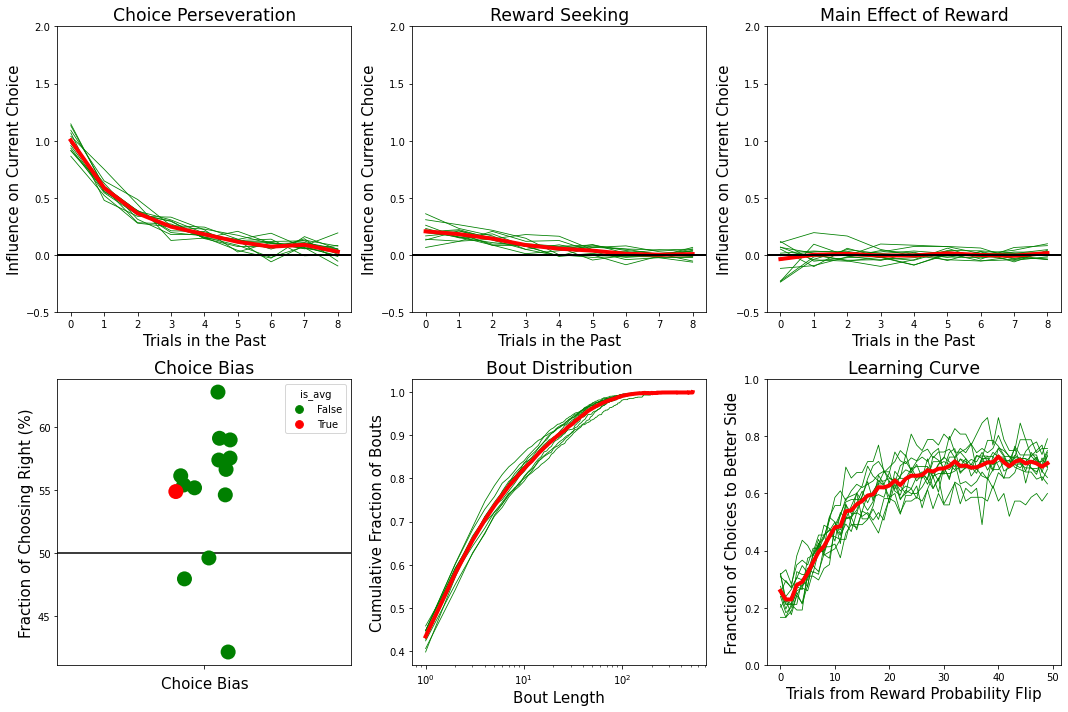

In [6]:
"""
Compute each diagnostics
"""

all_mice_weights = []
all_mice_left=[]
all_mice_right=[]
all_mice_total_x = []
all_mice_total_y = []
all_mice_learning_curve = []

for filename in behavior_filenames: 
  # print(filename)
  mousedata, even_data, odd_data = load_mousedata(filename)
  mouse_dataset, mouse_reward_probabilities = create_input_format(mousedata)

  # Trial history generalized linear model (GLM)
  mouse_weight = bandits_glm(nBack=10,data=mouse_dataset)
  all_mice_weights.append(mouse_weight)

  # Bias
  all_mice_left.append(compute_left_choice_bias(choices = mouse_dataset["choices"]))
  all_mice_right.append(compute_right_choice_bias(choices = mouse_dataset["choices"]))

  # Bout Distribution (different x and y axis for different mouse)
  mouse_x_axis, mouse_y_axis = bout_distribution(choices= mouse_dataset["choices"])
  all_mice_total_x.append(mouse_x_axis)
  all_mice_total_y.append(mouse_y_axis)

  # Learning Curve
  mouse_learning_curve = compute_learning_curve(reward_probabilities=mouse_reward_probabilities,
                                                choices = mouse_dataset["choices"], window=50)
  all_mice_learning_curve.append(mouse_learning_curve)

"""
Find the average of mice behavior
"""

# Find the mean GLM weights
mean_weights = np.mean(all_mice_weights, axis=0)
new_weights_list = np.vstack([all_mice_weights, mean_weights])

# Find the mean bias 
all_mice_right.append(np.mean(all_mice_right))
all_mice_right_bias_df = show_bias_graph(all_mice_right)

# Find the mean bout distribution
x, error = mean_bout_distribution(all_mice_total_x)
final_bout_distribution_x = np.ma.MaskedArray.tolist(x)
y, error = mean_bout_distribution(all_mice_total_y)
final_bout_distribution_y = np.ma.MaskedArray.tolist(y)

# Find the mean learning curve 
mean_learning_curve = np.mean(all_mice_learning_curve, axis=0)
new_learning_curve = np.vstack([all_mice_learning_curve,mean_learning_curve])

"""
Visualization 
"""

fig, axs = plt.subplots(2,3)
nBack=10

for i in range(13):
  axs[0,0].plot(new_weights_list[i][1:nBack], color='g', linewidth='0.8')
  axs[0,1].plot(new_weights_list[i][nBack+1:nBack*2], color='g', linewidth='0.8')
  axs[0,2].plot(new_weights_list[i][nBack*2+1:nBack*3], color='g',linestyle='solid',linewidth='0.8')
  axs[1,1].semilogx(all_mice_total_x[i], all_mice_total_y[i], color='g', linestyle='solid', linewidth='0.8')
  axs[1,2].plot(new_learning_curve[i], color='g', linestyle='solid', linewidth='0.8')

axs[0,0].plot(new_weights_list[13][1:nBack], label='mean', color='red', linewidth='4')
axs[0,0].set_title('Choice Perseveration', fontsize='xx-large') # choice weights
axs[0,0].set_xlabel('Trials in the Past', fontsize= 15)
axs[0,0].set_ylabel('Influence on Current Choice', fontsize= 15)
axs[0,0].set_ylim([-0.5,2])
axs[0,0].axhline(y=0, color='black', linestyle='-', linewidth='2')
axs[0,0].figure.set_size_inches(15,10)

axs[0,1].plot(new_weights_list[13][nBack+1:nBack*2], label='mean', color='red', linewidth='4')
axs[0,1].set_title('Reward Seeking', fontsize='xx-large')  # choice x rewards
axs[0,1].set_xlabel('Trials in the Past', fontsize=15)
axs[0,1].set_ylabel('Influence on Current Choice', fontsize=15)
axs[0,1].set_ylim([-0.5,2])
axs[0,1].axhline(y=0, color='black', linestyle='-', linewidth='2')
axs[0,1].figure.set_size_inches(15,10)

axs[0,2].plot(new_weights_list[13][nBack*2+1:nBack*3], label='mean', color='red',linestyle='solid',linewidth='4')
axs[0,2].set_title('Main Effect of Reward', fontsize='xx-large') # Reward Weights 
axs[0,2].set_xlabel('Trials in the Past', fontsize= 15)
axs[0,2].set_ylabel('Influence on Current Choice', fontsize= 15)
axs[0,2].set_ylim([-0.5,2])
axs[0,2].axhline(y=0, color='black', linestyle='-', linewidth='2')
axs[0,2].figure.set_size_inches(15,10)

g = sns.stripplot(ax=axs[1,0], data=all_mice_right_bias_df, x="Choice Bias", y="Fraction of Choosing Right (%)", hue="is_avg", s=15, palette=sns.color_palette(['g', 'red']))
g.set(xticklabels=[])
axs[1,0].axhline(50, color='black')
axs[1,0].set_title('Choice Bias', fontsize='xx-large')
axs[1,0].set_xlabel('Choice Bias', fontsize = 15)
axs[1,0].set_ylabel('Fraction of Choosing Right (%)', fontsize = 15)
axs[1,0].figure.set_size_inches(15,10)

axs[1,1].semilogx(final_bout_distribution_x, final_bout_distribution_y, color='red', linestyle = 'solid', linewidth='4')
axs[1,1].set_title('Bout Distribution', fontsize='xx-large')
axs[1,1].set_xlabel('Bout Length', fontsize=15)
axs[1,1].set_ylabel('Cumulative Fraction of Bouts', fontsize=15)
axs[1,1].figure.set_size_inches(15,10)

axs[1,2].plot(new_learning_curve[13], color='red', label='mean', linestyle='solid', linewidth='4')
axs[1,2].set_title('Learning Curve', fontsize='xx-large')
axs[1,2].set_xlabel('Trials from Reward Probability Flip', fontsize=15)
axs[1,2].set_ylabel('Franction of Choices to Better Side', fontsize=15)
axs[1,2].set_ylim([0,1])
axs[1,2].figure.set_size_inches(15,10)
  
plt.tight_layout()
plt.show()

***Qualitative diagnostics of agents' behavior with data visualization***

In [5]:
"""
You do not have to run this cell, if you are planning on running all of the mice.
However, run this cell if you want to look at only one mouse.
"""
# Example Mouse 
behavior_filenames = ['mousedata_AL038.csv']

In [7]:
"""
You have to run this cell in order to compile all of the models. 
This would take some time. 
"""
# Compilation of all models 
c_vanillaQ = pystan.StanModel(model_code=vanillaQ_model)
c_optimisticQ = pystan.StanModel(model_code=optimisticQ_model)
c_gen_local_matching = pystan.StanModel(model_code=generalized_local_matching_law_model)
c_forgettingQ = pystan.StanModel(model_code=forgettingQ_model)
c_basic_ideal_observer = pystan.StanModel(model_code=basic_ideal_observer_model)

c_dforgettingQ = pystan.StanModel(model_code=differential_forgettingQ_model)
c_habitsRL = pystan.StanModel(model_code=habitsRL_model)
c_ideal_observer_persev = pystan.StanModel(model_code=ideal_observer_1_back_perserveration_model)
c_ideal_observer_habits = pystan.StanModel(model_code=ideal_observer_habits_model)
c_mvt = pystan.StanModel(model_code=marginal_value_theorem_model)
c_models = [c_vanillaQ, c_optimisticQ, c_gen_local_matching, c_forgettingQ, c_basic_ideal_observer,
            c_dforgettingQ, c_habitsRL, c_ideal_observer_persev, c_ideal_observer_habits, c_mvt]

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5580d5ac86f661a73efac1c996721efd NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dc74b1adc1b8e8f2eb46a4f5c8a95d03 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5defe81af4a954390467e981c24448b2 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_de9a3911c658e8ef61603d6d8dcc01d0 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_009f32537acc13f07dec85fd70084b54 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b39ced5f6eb47b6355cf04a2d9ec6a05 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_759ab64df9a76bbe03d3f3c173b900dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a1ad4ed3ce64f9622d559bc292e03bb NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_816751c0cebede86b18768d6facbd326 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_368c2ccd1b6299afa8ff19a24ae556bf NOW.


mousedata: OrderedDict([('learning_rate', array(0.89756429)), ('decision_noise', array(0.00427885)), ('beta_bias', array(-3.09811032)), ('loglikelihood', array(-10905.9211983))])
VanillaQ Agent
OrderedDict([('learning_rate', array(0.64701227)), ('decision_noise', array(0.00140511)), ('beta_bias', array(-6.54915719)), ('loglikelihood', array(-11313.6092137))])
OrderedDict([('learning_rate', array(0.82337556)), ('decision_noise', array(0.02034661)), ('beta_bias', array(-0.76559203)), ('loglikelihood', array(-11307.31947773))])
OrderedDict([('learning_rate', array(0.76332633)), ('decision_noise', array(0.01149276)), ('beta_bias', array(-1.32395737)), ('loglikelihood', array(-11306.73640764))])
OrderedDict([('learning_rate', array(0.7428148)), ('decision_noise', array(-0.03056212)), ('beta_bias', array(0.39280009)), ('loglikelihood', array(-11310.22186316))])
OrderedDict([('learning_rate', array(0.69557893)), ('decision_noise', array(-0.00334853)), ('beta_bias', array(2.61108949)), ('logli

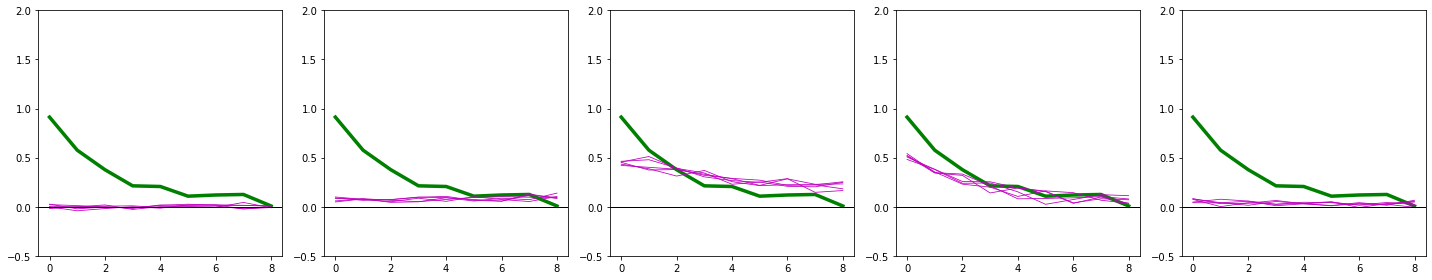

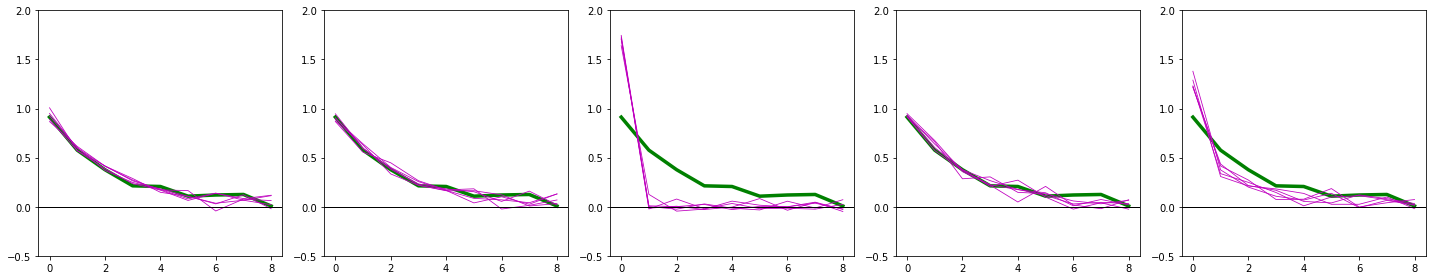

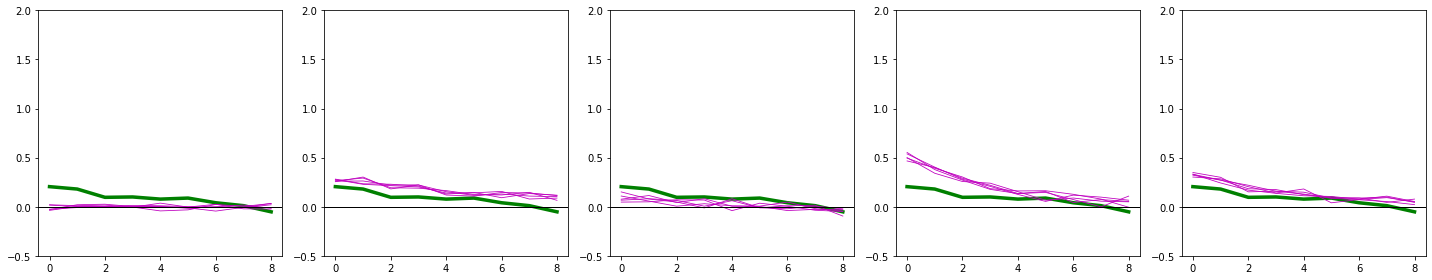

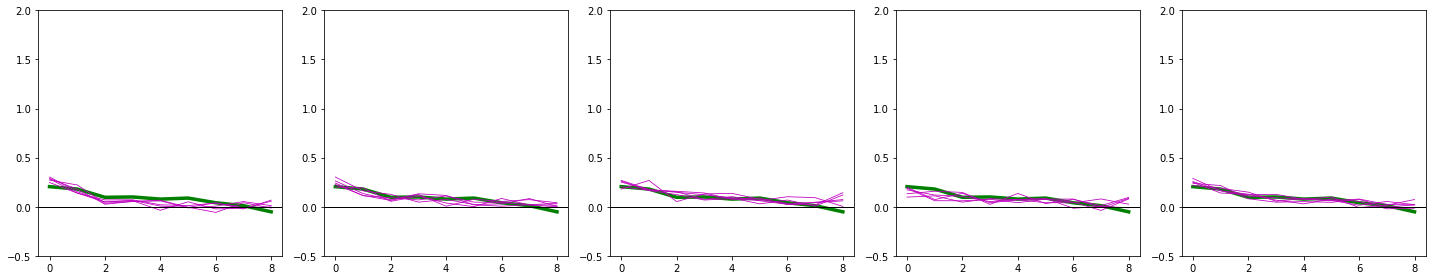

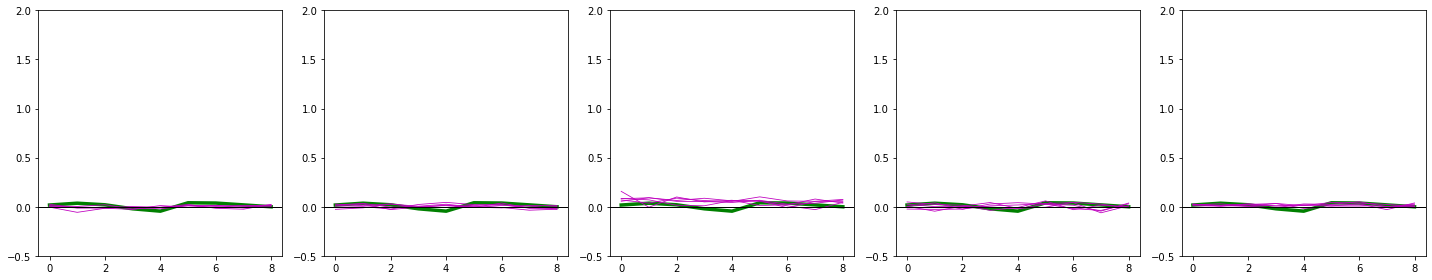

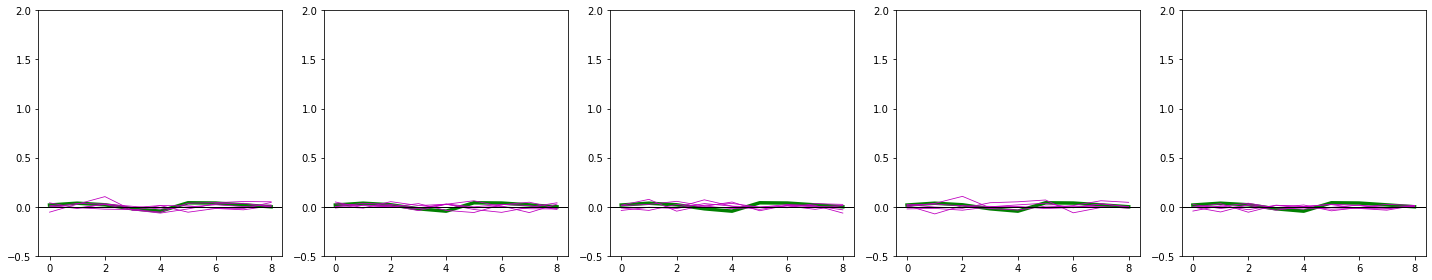

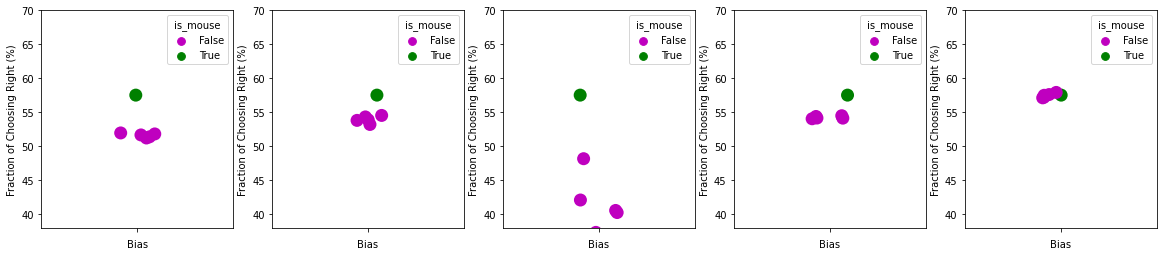

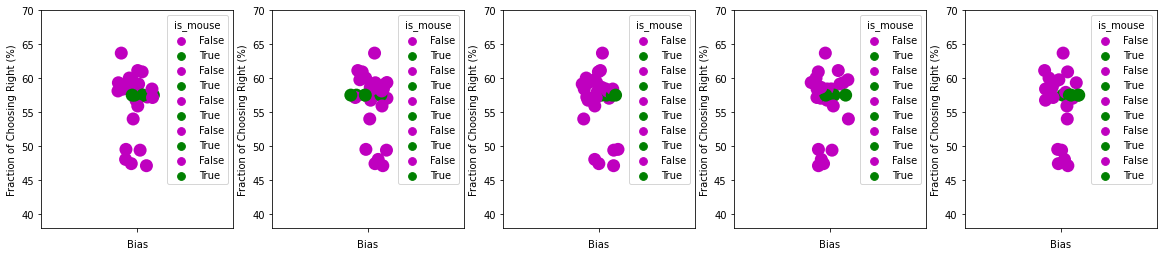

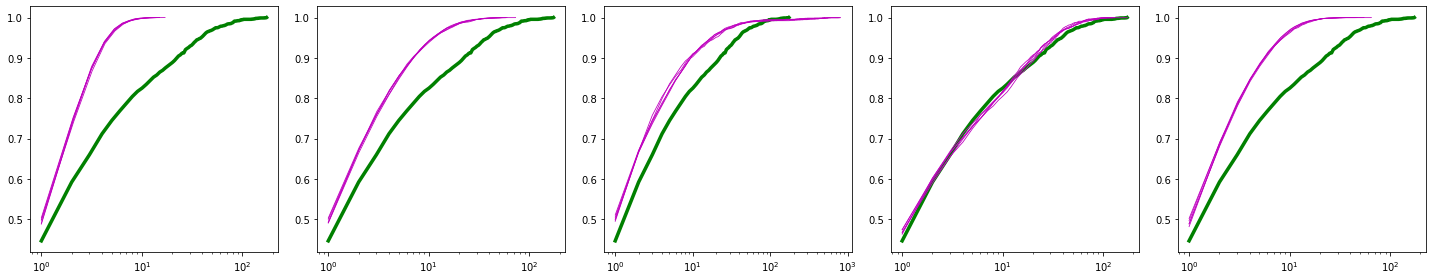

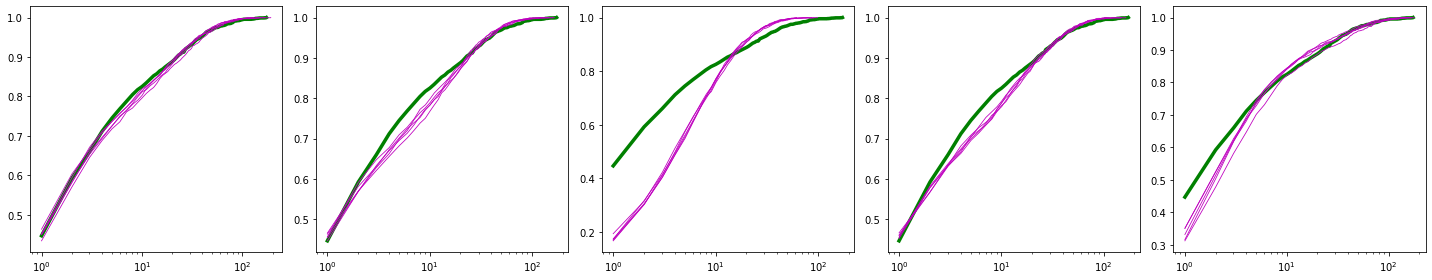

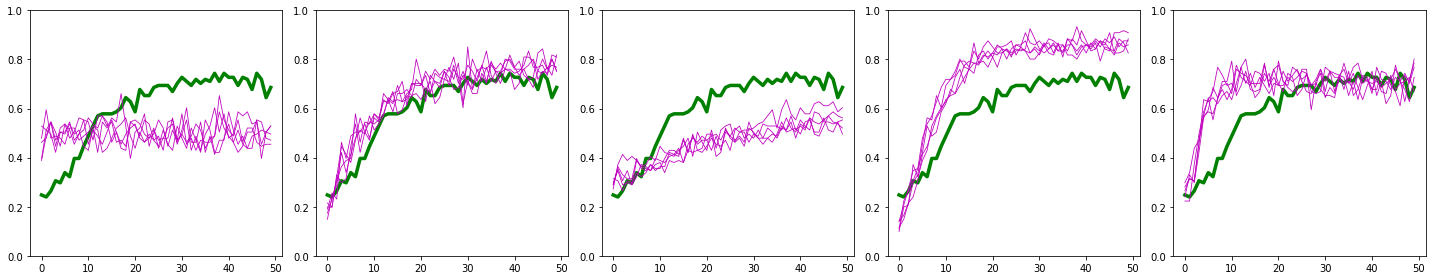

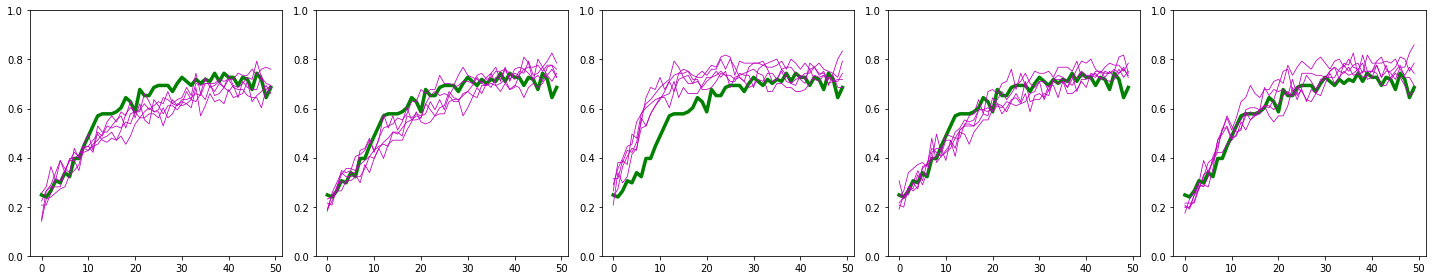

In [7]:
"""
Green color - mouse dataset 
Magenta color - 5 different synthetic datasets
1. Append the mouse dataset's qualitative diagnostics 
"""

for filename in behavior_filenames:
  # print(filename)

  # Trial History GLM weights 
  weights_list = []

  # Bias list
  total_right_bias = np.zeros((len(c_models),6))
  total_right_bias[:] = np.nan
  
  # Bout distribution x and y axis list
  total_x = []
  total_y = []

  # Learning curve list 
  learning_curve_list = []

  mousedata, even_data, odd_data = load_mousedata(filename)
  mouse_dataset, mouse_reward_probabilities = create_input_format(mousedata)

  # Bandits GLM [mouse]
  weights_basic = bandits_glm(nBack=10,data=mouse_dataset)
  weights_list.append(weights_basic)

  # Bias [mouse]
  total_right_bias[:,0] = compute_right_choice_bias(choices = mouse_dataset['choices'])

  # Bout Length [mouse]
  m_x_axis, m_y_axis = bout_distribution(choices = mouse_dataset["choices"])
  total_x.append(m_x_axis)
  total_y.append(m_y_axis)

  # Learning Curve [mouse]
  mouse_learning_curve = compute_learning_curve(reward_probabilities = mouse_reward_probabilities,
                                                choices = mouse_dataset["choices"], window=50)
  learning_curve_list.append(mouse_learning_curve)

  """
  2. Fit the model to the mouse dataset to obtain the hyperparameters fit to the mouse dataset.
     Use these hyperparameters to create each agent's synthetic dataset.
  """

  for model_name in c_models:
    mouse_param_est = fit_multiple_times(iternum = 3, model = model_name, dataset = mouse_dataset)
    print("mousedata:", mouse_param_est)

    if model_name == c_models[0]: #VanillaQ
      agent = vanillaQ_agent(learning_rate = mouse_param_est['learning_rate'], 
                             decision_noise = mouse_param_est['decision_noise'], 
                             beta_bias = mouse_param_est['beta_bias'])
      print("VanillaQ Agent")
    
    elif model_name == c_models[1]: #optimisticQ
      agent = optimisticQ_agent(learning_rate_pos = mouse_param_est['learning_rate_pos'], 
                                learning_rate_neg = mouse_param_est['learning_rate_neg'], 
                                decision_noise = mouse_param_est['decision_noise'], 
                                beta_bias = mouse_param_est['beta_bias'])
      print("OptimisticQ Agent")
    
    elif model_name == c_models[2]: #matching law
      agent = generalized_local_matching_law_agent(learning_rate = mouse_param_est['learning_rate'],
                                                   sensitivity = mouse_param_est['sensitivity'],
                                                   bias = mouse_param_est['bias'])
      print("Generalized Local Matching Law Agent")
    
    elif model_name == c_models[3]: #forgettingQ
      agent = forgettingQ_agent(learning_rate = mouse_param_est['learning_rate'], 
                                reward_strength = mouse_param_est['reward_strength'], 
                                aversion_strength = mouse_param_est['aversion_strength'],
                                beta_bias = mouse_param_est['beta_bias'])
      print("ForgettingQ Agent")
    
    elif model_name == c_models[4]: # Basic Ideal Observer 
      agent = basic_ideal_observer_agent(beta_v = mouse_param_est['beta_v'], 
                                         beta_bias = mouse_param_est['beta_bias'])
      print('Basic Ideal Observer')

    elif model_name == c_models[5]: #Differential Forgetting Q
      agent = differential_forgettingQ_agent(learning_rate = mouse_param_est['learning_rate'], 
                                             forgetting_rate = mouse_param_est['forgetting_rate'], 
                                             reward_strength = mouse_param_est['reward_strength'], 
                                             aversion_strength = mouse_param_est['aversion_strength'], 
                                             beta_bias = mouse_param_est["beta_bias"])
      print("Differential ForgettingQ Agent")

    elif model_name == c_models[6]: #Mixture of Agents 
      agent = habitsRL_agent(alpha_rl = mouse_param_est['alpha_rl'], 
                             alpha_habit = mouse_param_est['alpha_habit'], 
                             beta_rl = mouse_param_est['beta_rl'], 
                             beta_habit = mouse_param_est['beta_habit'], 
                             beta_bias = mouse_param_est['beta_bias'])
      print('Habits RL Agent')

    elif model_name == c_models[7]: # Ideal Observer with Perseveration
      agent = ideal_observer_1_back_perserveration_agent(beta_v = mouse_param_est['beta_v'], 
                                                         beta_bias = mouse_param_est['beta_bias'], 
                                                         beta_perserv = mouse_param_est['beta_perserv'])
      print('Ideal Observer with perseveration (1-back) Agent')
    
    elif model_name == c_models[8]: #Ideal Observer with Habits 
      agent = ideal_observer_habits_agent(beta_v = mouse_param_est['beta_v'], 
                                          beta_habit = mouse_param_est['beta_habit'], 
                                          alpha_habit = mouse_param_est['alpha_habit'], 
                                          beta_bias = mouse_param_est['beta_bias'])
      print('Ideal Observer with Habits Agent') 

    elif model_name == c_models[9]: # Marginal Value Theorem 
      agent = marginal_value_theorem_agent(alpha_l = mouse_param_est['alpha_l'],
                                           beta = mouse_param_est['beta'],
                                           beta_bias = mouse_param_est['beta_bias'])
      print('Marginal Value Theorem Agent')

    """
    3. Input the synthetic datasets to each qualitative diagnostics 
       cf. Different run trials is used for different sets of models.
    """

    list_of_dict = []
    for i in range(5):
      environment = TwoArmedBanditTask(total_trials = mouse_dataset['nTrials'], reward_prob = mouse_reward_probabilities)
      if (model_name == c_models[0]) or (model_name == c_models[1]) or (model_name == c_models[2]) or (model_name == c_models[3]) or (model_name == c_models[5]) or (model_name == c_models[6]):
        synthetic_choices, synthetic_rewards, synthetic_belief = run_trials(agent, environment, mouse_dataset)
      elif (model_name == c_models[4]) or (model_name == c_models[7]) or (model_name == c_models[8]):
        synthetic_choices, synthetic_rewards, synthetic_belief = run_trials_for_ideal_observer(agent, environment, mouse_dataset)
      else:
        synthetic_choices, synthetic_rewards, synthetic_belief = run_trials_for_mvt(agent, environment, mouse_dataset)
      synthetic_dict = {'nTrials': mouse_dataset['nTrials'], 'nSession': mouse_dataset['nSession'], 
                        'session_index': mouse_dataset['session_index'],'choices': synthetic_choices, 'rewards': synthetic_rewards}
      synthethic_param_est=fit_multiple_times(iternum = 5, model = model_name, dataset = synthetic_dict)
      list_of_dict.append(synthetic_dict)
      print(synthethic_param_est)

      # Bandits GLM (synthetic data)
      synthetic_weights = bandits_glm(nBack=10, data=synthetic_dict)
      weights_list.append(synthetic_weights)

      # Bias (synthetic data)
      if model_name == c_models[0]: # vanilla Q
        total_right_bias[0,i+1] = compute_right_choice_bias(synthetic_dict['choices'])
      elif model_name == c_models[1]: # optimistic Q
        total_right_bias[1,i+1] = compute_right_choice_bias(synthetic_dict['choices'])
      elif model_name == c_models[2]: # generalized local matching law 
        total_right_bias[2,i+1] = compute_right_choice_bias(synthetic_dict['choices'])
      elif model_name == c_models[3]: # forgetting Q 
        total_right_bias[3,i+1] = compute_right_choice_bias(synthetic_dict['choices'])
      elif model_name == c_models[4]: # basic ideal observer 
        total_right_bias[4,i+1] = compute_right_choice_bias(synthetic_dict['choices'])
      elif model_name == c_models[5]: # DFQ
        total_right_bias[5,i+1] = compute_right_choice_bias(synthetic_dict['choices'])
      elif model_name == c_models[6]: # habits RL 
        total_right_bias[6,i+1] = compute_right_choice_bias(synthetic_dict['choices'])
      elif model_name == c_models[7]: # ideal observer with 1-back perseveration 
        total_right_bias[7,i+1] = compute_right_choice_bias(synthetic_dict['choices'])
      elif model_name == c_models[8]: # ideal observer with habits 
        total_right_bias[8,i+1] = compute_right_choice_bias(synthetic_dict['choices'])
      elif model_name == c_models[9]: # marginal value theorem 
        total_right_bias[9,i+1] = compute_right_choice_bias(synthetic_dict['choices'])

      # Bout Length (synthetic data)
      syn_x_axis, syn_y_axis = bout_distribution(choices=synthetic_dict["choices"])
      total_x.append(syn_x_axis)
      total_y.append(syn_y_axis)

      # Learning Curve (synthetic data)
      syn_learning_curve = compute_learning_curve(reward_probabilities=mouse_reward_probabilities, choices=synthetic_dict["choices"], window=50)
      learning_curve_list.append(syn_learning_curve)

      agent.reset_index()

  """
  4. Visualization 
    Due to plotting 10 models, I have divided into half.
    - First group: vanillaQ, optimisticQ, generalized local matching law, forgettingQ, basic ideal observer agents
    - Second group: differential forgetting Q, habitsRL, ideal observer with 1-back perseveration, ideal observer with habits, marginal value theorem 
  """
  # Make the right bias ready to be plot (make the data to be easier to work with the stripplot)
  # I
  ready_right_Q = show_mouse_agent_bias_graph(total_right_bias[0,:])
  ready_right_OQ = show_mouse_agent_bias_graph(total_right_bias[1,:])
  ready_right_matching = show_mouse_agent_bias_graph(total_right_bias[2,:])
  ready_right_FQ = show_mouse_agent_bias_graph(total_right_bias[3,:])
  ready_right_ideal = show_mouse_agent_bias_graph(total_right_bias[4,:])
  # II
  ready_right_DFQ = show_mouse_agent_bias_graph(total_right_bias[5,:])
  ready_right_habit = show_mouse_agent_bias_graph(total_right_bias[6,:])
  ready_right_persev = show_mouse_agent_bias_graph(total_right_bias[7,:])
  ready_right_ideal_habit = show_mouse_agent_bias_graph(total_right_bias[8,:])
  ready_right_mvt = show_mouse_agent_bias_graph(total_right_bias[9,:])

  list_of_bias = [ready_right_Q, ready_right_OQ, ready_right_matching, ready_right_FQ, ready_right_ideal,
                  ready_right_DFQ, ready_right_habit, ready_right_persev, ready_right_ideal_habit, ready_right_mvt]

  #trial history glm (choice) I [vanillaQ, optimistic Q, local matching, FQ, ideal observer]
  fig, axs = plt.subplots(1,5)
  a=0
  nBack=10
  for i in [1,6,11,16,21]:
    axs[a].plot(weights_list[0][1:nBack], label='mousedata', color='g', linestyle='solid', linewidth='3.5')
    axs[a].plot(weights_list[i][1:nBack], label='syn_data1', color='m', linestyle='solid', linewidth='0.8')
    axs[a].plot(weights_list[i+1][1:nBack], label='syn_data2', color='m',linestyle='solid',linewidth='0.8')
    axs[a].plot(weights_list[i+2][1:nBack], label='syn_data3', color='m',linestyle='solid',linewidth='0.8')
    axs[a].plot(weights_list[i+3][1:nBack], label='syn_data4', color='m',linestyle='solid',linewidth='0.8')
    axs[a].plot(weights_list[i+4][1:nBack], label='syn_data5', color='m',linestyle='solid',linewidth='0.8')
    # axs[a].set_title('Choice Perseveration', fontsize='x-large')
    # axs[a].set_xlabel('Trials in the Past', fontsize='large')
    # axs[a].set_ylabel('Influence on Current Choice', fontsize='large')
    axs[a].set_ylim([-0.5,2])
    axs[a].axhline(y=0, color='black', linestyle='-', linewidth='1')
    axs[a].figure.set_size_inches(20,4)
    plt.tight_layout()
    a+=1
  plt.show()

  # trial history glm (choice) II [DFQ, Mixture-of-Agents, Ideal Observer with 1-back Perseveration, Ideal Observer with Habit, MVT]
  fig, axs = plt.subplots(1,5)
  b=0
  for i in [26,31,36,41,46]:
    axs[b].plot(weights_list[0][1:nBack], label='mousedata', color='g', linestyle='solid', linewidth='3.5')
    axs[b].plot(weights_list[i][1:nBack], label='syn_data1', color='m', linestyle='solid',linewidth='0.8')
    axs[b].plot(weights_list[i+1][1:nBack], label='syn_data2', color='m',linestyle='solid',linewidth='0.8')
    axs[b].plot(weights_list[i+2][1:nBack], label='syn_data3', color='m',linestyle='solid',linewidth='0.8')
    axs[b].plot(weights_list[i+3][1:nBack], label='syn_data4', color='m',linestyle='solid',linewidth='0.8')
    axs[b].plot(weights_list[i+4][1:nBack], label='syn_data5', color='m',linestyle='solid',linewidth='0.8')
    # axs[b].set_title('Choice Perseveration', fontsize='x-large')
    # axs[b].set_xlabel('Trials in the Past', fontsize='large')
    # axs[b].set_ylabel('Influence on Current Choice', fontsize='large')
    axs[b].set_ylim([-0.5,2])
    axs[b].axhline(y=0, color='black', linestyle='-', linewidth='1')
    axs[b].figure.set_size_inches(20,4)
    plt.tight_layout()
    b+=1
  plt.show()

  # trial history glm (choice*reward) I
  fig, axs = plt.subplots(1,5)
  c=0
  for i in [1,6,11,16,21]:
    axs[c].plot(weights_list[0][nBack+1:nBack*2], label='mousedata', color='g', linestyle='solid', linewidth='3.5')
    axs[c].plot(weights_list[i][nBack+1:nBack*2], label='syn_data1', color='m',linestyle='solid',linewidth='0.8')
    axs[c].plot(weights_list[i+1][nBack+1:nBack*2], label='syn_data2', color='m',linestyle='solid',linewidth='0.8')
    axs[c].plot(weights_list[i+2][nBack+1:nBack*2], label='syn_data3', color='m',linestyle='solid',linewidth='0.8')
    axs[c].plot(weights_list[i+3][nBack+1:nBack*2], label='syn_data4', color='m',linestyle='solid',linewidth='0.8')
    axs[c].plot(weights_list[i+4][nBack+1:nBack*2], label='syn_data5', color='m',linestyle='solid',linewidth='0.8')
    # axs[c].set_title('Reward Seeking', fontsize='x-large')
    # axs[c].set_xlabel('Trials in the Past', fontsize='large')
    # axs[c].set_ylabel('Influence on Current Choice', fontsize='large')
    axs[c].set_ylim([-0.5,2])
    axs[c].axhline(y=0, color='black', linestyle='-', linewidth='1')
    axs[c].figure.set_size_inches(20,4)
    plt.tight_layout()
    c+=1
  plt.show()

  # trial history glm (choice*reward) II
  fig, axs = plt.subplots(1,5)
  d=0
  for i in [26,31,36,41,46]:
    axs[d].plot(weights_list[0][nBack+1:nBack*2], label='mousedata', color='g', linestyle='solid', linewidth='3.5')
    axs[d].plot(weights_list[i][nBack+1:nBack*2], label='syn_data1', color='m',linestyle='solid',linewidth='0.8')
    axs[d].plot(weights_list[i+1][nBack+1:nBack*2], label='syn_data2', color='m',linestyle='solid',linewidth='0.8')
    axs[d].plot(weights_list[i+2][nBack+1:nBack*2], label='syn_data3', color='m',linestyle='solid',linewidth='0.8')
    axs[d].plot(weights_list[i+3][nBack+1:nBack*2], label='syn_data4', color='m',linestyle='solid',linewidth='0.8')
    axs[d].plot(weights_list[i+4][nBack+1:nBack*2], label='syn_data5', color='m',linestyle='solid',linewidth='0.8')
    # axs[d].set_title('Reward Seeking', fontsize='x-large')
    # axs[d].set_xlabel('Trials in the Past', fontsize='large')
    # axs[d].set_ylabel('Regression Weights', fontsize='large')
    axs[d].set_ylim([-0.5,2])
    axs[d].axhline(y=0, color='black', linestyle='-', linewidth='1')
    axs[d].figure.set_size_inches(20,4)
    plt.tight_layout()
    d+=1
  plt.show()

  # trial history glm (reward) I
  fig, axs = plt.subplots(1,5)
  e=0
  for i in [1,6,11,16,21]:  
    axs[e].plot(weights_list[0][nBack*2+1:nBack*3], label='mousedata', color='g', linestyle='solid', linewidth='3.5')
    axs[e].plot(weights_list[i][nBack*2+1:nBack*3], label='syn_data1', color='m',linestyle='solid',linewidth='0.8')
    axs[e].plot(weights_list[i+1][nBack*2+1:nBack*3], label='syn_data2', color='m',linestyle='solid',linewidth='0.8')
    axs[e].plot(weights_list[i+2][nBack*2+1:nBack*3], label='syn_data3', color='m',linestyle='solid',linewidth='0.8')
    axs[e].plot(weights_list[i+3][nBack*2+1:nBack*3], label='syn_data4', color='m',linestyle='solid',linewidth='0.8')
    axs[e].plot(weights_list[i+4][nBack*2+1:nBack*3], label='syn_data5', color='m',linestyle='solid',linewidth='0.8')
    # axs[e].set_title('Main Effect of Reward', fontsize='x-large') 
    # axs[e].set_xlabel('Trials in the Past', fontsize='large')
    # axs[e].set_ylabel('Regression Weights', fontsize='large')
    axs[e].set_ylim([-0.5,2])
    axs[e].axhline(y=0, color='black', linestyle='-', linewidth='1')
    axs[e].figure.set_size_inches(20,4)
    plt.tight_layout()
    e+=1
  plt.show()

  # trial history glm (reward) II 
  fig, axs = plt.subplots(1,5)
  f=0
  for i in [26,31,36,41,46]:
    axs[f].plot(weights_list[0][nBack*2+1:nBack*3], label='mousedata', color='g', linestyle='solid', linewidth='3.5')
    axs[f].plot(weights_list[i][nBack*2+1:nBack*3], label='syn_data1', color='m',linestyle='solid',linewidth='0.8')
    axs[f].plot(weights_list[i+1][nBack*2+1:nBack*3], label='syn_data2', color='m',linestyle='solid',linewidth='0.8')
    axs[f].plot(weights_list[i+2][nBack*2+1:nBack*3], label='syn_data3', color='m',linestyle='solid',linewidth='0.8')
    axs[f].plot(weights_list[i+3][nBack*2+1:nBack*3], label='syn_data4', color='m',linestyle='solid',linewidth='0.8')
    axs[f].plot(weights_list[i+4][nBack*2+1:nBack*3], label='syn_data5', color='m',linestyle='solid',linewidth='0.8')
    # axs[f].set_title('Main Effect of Reward', fontsize='x-large') 
    # axs[f].set_xlabel('Trials in the Past', fontsize='large')
    # axs[f].set_ylabel('Regression Weights', fontsize='large')
    axs[f].set_ylim([-0.5,2])
    axs[f].axhline(y=0, color='black', linestyle='-', linewidth='1')
    axs[f].figure.set_size_inches(20,4)
    plt.tight_layout()
    f+=1
  plt.show()

  # Bias I 
  fig, axs = plt.subplots(1,5)
  for i in range(5):
    bias_I = sns.stripplot(ax=axs[i], data=list_of_bias[i], x="Bias", y="Fraction of Choosing Right (%)", 
                           hue="is_mouse", s=13, palette=sns.color_palette(['m', 'g']))
    bias_I.set(xticklabels=[])
    # bias_I.set_xlabel('Bias', fontsize='large')
    # bias_I.set_ylabel('Fraction of Choosing Right (%)', fontsize='large')
    bias_I.set_ylim([38,70])
    bias_I.figure.set_size_inches(20,4)
  plt.show()
  
  # Bias II 
  fig, axs = plt.subplots(1,5)
  for j in range(5):
    for i in range(5,10):
      bias_II = sns.stripplot(ax=axs[j], data=list_of_bias[i], x="Bias", y="Fraction of Choosing Right (%)", 
                              hue="is_mouse", s=13, palette=sns.color_palette(['m', 'g']))
      bias_II.set(xticklabels=[])
      # bias_II.set_xlabel('Bias', fontsize='large')
      # bias_II.set_ylabel('Fraction of Choosing Right (%)', fontsize='large')
      bias_II.set_ylim([38,70])
      bias_II.figure.set_size_inches(20,4)

  # Bout distribution I 
  fig, axs = plt.subplots(1,5)
  j=0
  for i in [1,6,11,16,21]:   
    axs[j].semilogx(total_x[0],total_y[0], label='mousedata', color='g', linestyle='solid', linewidth='3.5')
    axs[j].semilogx(total_x[i],total_y[i], label='syn_data1', color='m', linestyle='solid', linewidth='0.8')
    axs[j].semilogx(total_x[i+1],total_y[i+1], label='syn_data2', color='m', linestyle='solid', linewidth='0.8')
    axs[j].semilogx(total_x[i+2],total_y[i+2], label='syn_data3', color='m', linestyle='solid', linewidth='0.8')
    axs[j].semilogx(total_x[i+3],total_y[i+3], label='syn_data4', color='m', linestyle='solid', linewidth='0.8')
    axs[j].semilogx(total_x[i+4],total_y[i+4], label='syn_data5', color='m', linestyle='solid', linewidth='0.8')
    # axs[j].set_title('Bout Distribution', fontsize='x-large')
    # axs[j].set_xlabel('Bout Length', fontsize='large')
    # axs[j].set_ylabel('Number of Bouts', fontsize='large')
    # axs[j].set_xlim([-1,200])
    # axs[j].set_xlim([0,10])
    axs[j].figure.set_size_inches(20,4)
    plt.tight_layout()
    j+=1
  plt.show()

  # Bout distribution II
  fig, axs = plt.subplots(1,5)
  h=0
  for i in [26,31,36,41,46]:
    axs[h].semilogx(total_x[0],total_y[0], label='mousedata', color='g', linestyle='solid', linewidth='3.5')
    axs[h].semilogx(total_x[i],total_y[i], label='syn_data1', color='m', linestyle='solid', linewidth='0.8')
    axs[h].semilogx(total_x[i+1],total_y[i+1], label='syn_data2', color='m', linestyle='solid', linewidth='0.8')
    axs[h].semilogx(total_x[i+2],total_y[i+2], label='syn_data3', color='m', linestyle='solid', linewidth='0.8')
    axs[h].semilogx(total_x[i+3],total_y[i+3], label='syn_data4', color='m', linestyle='solid', linewidth='0.8')
    axs[h].semilogx(total_x[i+4],total_y[i+4], label='syn_data5', color='m', linestyle='solid', linewidth='0.8')
    # axs[h].set_title('Bout Distribution', fontsize='x-large')
    # axs[h].set_xlabel('Bout Length', fontsize='large')
    # axs[h].set_ylabel('Number of Bouts', fontsize='large')
    # axs[h].set_xlim([-1,200])
    # axs[h].set_xlim([0,10])
    axs[h].figure.set_size_inches(20,4)
    plt.tight_layout()
    h+=1
  plt.show()

  # Learning Curve I 
  fig, axs = plt.subplots(1,5)
  k=0
  for i in [1,6,11,16,21]: 
    axs[k].plot(learning_curve_list[0], label='mousedata', color='g', linestyle='solid', linewidth='3.5')
    axs[k].plot(learning_curve_list[i], label='syn_data 1', color='m',linestyle='solid',linewidth='0.8')
    axs[k].plot(learning_curve_list[i+1], label='syn_data 2', color='m',linestyle='solid',linewidth='0.8')
    axs[k].plot(learning_curve_list[i+2], label='syn_data 3', color='m',linestyle='solid',linewidth='0.8')
    axs[k].plot(learning_curve_list[i+3], label='syn_data 4', color='m',linestyle='solid',linewidth='0.8')
    axs[k].plot(learning_curve_list[i+4], label='syn_data 5', color='m',linestyle='solid',linewidth='0.8')
    # axs[k].set_title('Learning Curve', fontsize='x-large')
    # axs[k].set_xlabel('Trials from reward probability flip', fontsize='large')
    # axs[k].set_ylabel('Franction of choices to better side', fontsize='large')
    axs[k].set_ylim([0,1])
    axs[k].figure.set_size_inches(20,4)    
    plt.tight_layout()
    k+=1
  plt.show()

  # Learning Curve II 
  fig, axs = plt.subplots(1,5)
  l=0
  for i in [26,31,36,41, 46]:
    axs[l].plot(learning_curve_list[0], label='mousedata', color='g', linestyle='solid', linewidth='3.5')
    axs[l].plot(learning_curve_list[i], label='syn_data 1', color='m',linestyle='solid',linewidth='0.8')
    axs[l].plot(learning_curve_list[i+1], label='syn_data 2', color='m',linestyle='solid',linewidth='0.8')
    axs[l].plot(learning_curve_list[i+2], label='syn_data 3', color='m',linestyle='solid',linewidth='0.8')
    axs[l].plot(learning_curve_list[i+3], label='syn_data 4', color='m',linestyle='solid',linewidth='0.8')
    axs[l].plot(learning_curve_list[i+4], label='syn_data 5', color='m',linestyle='solid',linewidth='0.8')
    # axs[l].set_title('Learning Curve', fontsize='x-large')
    # axs[l].set_xlabel('Trials from reward probability flip', fontsize='large')
    # axs[l].set_ylabel('Franction of choices to better side', fontsize='large')
    axs[l].set_ylim([0,1])
    axs[l].figure.set_size_inches(20,4)    
    plt.tight_layout()
    l+=1
  plt.show() 

***Quantitative comparison between synthetic agents with data visualization***

mousedata_AL038.csv
Even dataset parameter est: OrderedDict([('learning_rate', array(0.382292)), ('decision_noise', array(0.00678535)), ('beta_bias', array(-1.76334813)), ('loglikelihood', array(-4823.25162474))])
Odd dataset parameter est: OrderedDict([('learning_rate', array(0.90194589)), ('decision_noise', array(-0.0037097)), ('beta_bias', array(3.05246799)), ('loglikelihood', array(-6052.92258085))])
Even dataset parameter est: OrderedDict([('learning_rate_pos', array(0.32389205)), ('learning_rate_neg', array(0.80310268)), ('decision_noise', array(-0.00072686)), ('beta_bias', array(19.42015723)), ('loglikelihood', array(-4851.36801964))])
Odd dataset parameter est: OrderedDict([('learning_rate_pos', array(0.11967697)), ('learning_rate_neg', array(0.35721694)), ('decision_noise', array(3.2314054)), ('beta_bias', array(-0.00265105)), ('loglikelihood', array(-4460.40720478))])
Even dataset parameter est: OrderedDict([('learning_rate', array(0.11707606)), ('sensitivity', array(0.414556

<Figure size 21600x23760 with 0 Axes>

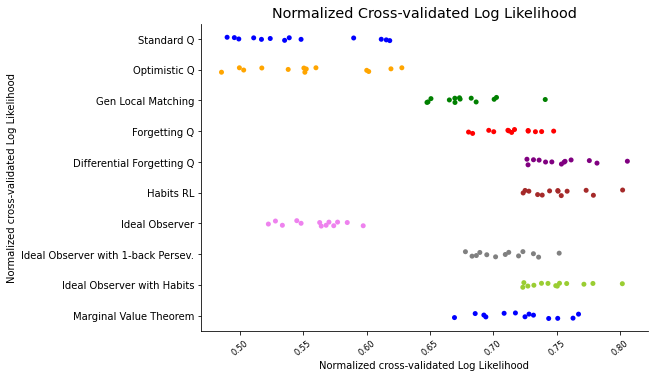

<Figure size 21600x23760 with 0 Axes>

In [8]:
# Set up the data
loglikelihood = np.zeros((len(c_models),len(behavior_filenames)))
cross_validated_loglikelihood = np.zeros((len(c_models),len(behavior_filenames)))

# Computing the log likelihood and cross-validated log likelihood 
for index, filename in enumerate(behavior_filenames):
  print(filename)
  mousedata, even_data, odd_data = load_mousedata(filename)
  mouse_dataset, _ = create_input_format(mousedata)
  even_dataset, even_reward_probabilities = create_input_format(even_data)
  odd_dataset, odd_reward_probabilities = create_input_format(odd_data)

  for model in c_models:
    even_param_est = fit_multiple_times(5, model, even_dataset)
    print("Even dataset parameter est:", even_param_est)
    odd_param_est = fit_multiple_times(5, model, odd_dataset)
    print("Odd dataset parameter est:", odd_param_est)

    if model == c_models[0]:        # vanillaQ
      odd_instance = vanillaQ_agent(learning_rate = odd_param_est['learning_rate'],
                                             decision_noise = odd_param_est['decision_noise'],
                                             beta_bias = odd_param_est['beta_bias'])
      even_instance = vanillaQ_agent(learning_rate = even_param_est['learning_rate'], 
                                              decision_noise = even_param_est['decision_noise'],
                                              beta_bias = even_param_est['beta_bias'])
      vanillaQ_loglik, vanillaQ_crossval_loglik = create_total_log_likelihood(odd_instance, even_instance, 
                                                                              odd_dataset, even_dataset, mouse_dataset)
      loglikelihood[0,index] = vanillaQ_loglik
      cross_validated_loglikelihood[0,index] = vanillaQ_crossval_loglik

    elif model == c_models[1]:      #optimistic Q
      odd_instance = optimisticQ_agent(learning_rate_pos = odd_param_est['learning_rate_pos'],
                                       learning_rate_neg = odd_param_est['learning_rate_neg'],
                                       decision_noise = odd_param_est['decision_noise'],
                                       beta_bias = odd_param_est['beta_bias'])
      even_instance = optimisticQ_agent(learning_rate_pos = even_param_est['learning_rate_pos'],
                                        learning_rate_neg = even_param_est['learning_rate_neg'], 
                                        decision_noise = even_param_est['decision_noise'],
                                        beta_bias = even_param_est['beta_bias'])
      optQ_loglik, optQ_crossval_loglik = create_total_log_likelihood(odd_instance, even_instance, 
                                                                      odd_dataset, even_dataset, mouse_dataset)
      loglikelihood[1,index] = optQ_loglik
      cross_validated_loglikelihood[1,index] = optQ_crossval_loglik

    elif model == c_models[2]:       #generalized local matching law 
      odd_instance = generalized_local_matching_law_agent(learning_rate = odd_param_est['learning_rate'],
                                                          sensitivity = odd_param_est['sensitivity'],
                                                          bias = odd_param_est['bias'])
      even_instance = generalized_local_matching_law_agent(learning_rate = even_param_est['learning_rate'],
                                                           sensitivity = even_param_est['sensitivity'],
                                                           bias = even_param_est['bias'])
      matching_loglik, matching_crosval_loglik = create_total_log_likelihood(odd_instance, even_instance,
                                                                             odd_dataset, even_dataset, mouse_dataset)
      loglikelihood[2,index] = matching_loglik
      cross_validated_loglikelihood[2,index] = matching_crosval_loglik

    elif model == c_models[3]:       #forgettingQ
      odd_instance = forgettingQ_agent(learning_rate = odd_param_est['learning_rate'],
                                       reward_strength = odd_param_est['reward_strength'],
                                       aversion_strength = odd_param_est['aversion_strength'],
                                       beta_bias = odd_param_est['beta_bias'])
      even_instance = forgettingQ_agent(learning_rate = even_param_est['learning_rate'],
                                        reward_strength = even_param_est['reward_strength'],
                                        aversion_strength = even_param_est['aversion_strength'],
                                        beta_bias = even_param_est['beta_bias'])
      forgettingQ_loglik, forgettingQ_crossval_loglik = create_total_log_likelihood(odd_instance, even_instance,
                                                                                    odd_dataset, even_dataset, mouse_dataset)
      loglikelihood[3,index] = forgettingQ_loglik
      cross_validated_loglikelihood[3,index] = forgettingQ_crossval_loglik
    
    elif model == c_models[5]:        # differential forgetting Q
      odd_instance = differential_forgettingQ_agent(learning_rate = odd_param_est['learning_rate'], 
                                                    forgetting_rate = odd_param_est['forgetting_rate'], 
                                                    reward_strength = odd_param_est['reward_strength'], 
                                                    aversion_strength = odd_param_est['aversion_strength'], 
                                                    beta_bias = odd_param_est["beta_bias"])
      even_instance = differential_forgettingQ_agent(learning_rate = even_param_est['learning_rate'], 
                                                     forgetting_rate = even_param_est['forgetting_rate'], 
                                                     reward_strength = even_param_est['reward_strength'], 
                                                     aversion_strength = even_param_est['aversion_strength'], 
                                                     beta_bias = even_param_est["beta_bias"])
      dfq_loglik, dfq_crossval_loglik = create_total_log_likelihood(odd_instance, even_instance,
                                                                    odd_dataset, even_dataset, mouse_dataset)
      loglikelihood[4,index] = dfq_loglik
      cross_validated_loglikelihood[4,index] = dfq_crossval_loglik

    elif model == c_models[6]:        # habits RL 
      odd_instance = habitsRL_agent(alpha_rl = odd_param_est['alpha_rl'], 
                                    alpha_habit = odd_param_est['alpha_habit'], 
                                    beta_rl = odd_param_est['beta_rl'], 
                                    beta_habit = odd_param_est['beta_habit'],
                                    beta_bias = odd_param_est['beta_bias'])
      even_instance = habitsRL_agent(alpha_rl = even_param_est['alpha_rl'], 
                                     alpha_habit = even_param_est['alpha_habit'], 
                                     beta_rl = even_param_est['beta_rl'], 
                                     beta_habit = even_param_est['beta_habit'],
                                     beta_bias = even_param_est['beta_bias'])
      habitsRL_loglik, habitsRL_crossval_loglik = create_total_log_likelihood(odd_instance, even_instance, 
                                                                              odd_dataset, even_dataset, mouse_dataset)
      loglikelihood[5,index] = habitsRL_loglik
      cross_validated_loglikelihood[5,index] = habitsRL_crossval_loglik

    elif model == c_models[4]:       # Basic Ideal observer 
      odd_instance = basic_ideal_observer_agent(beta_v = odd_param_est['beta_v'],
                                                beta_bias = odd_param_est['beta_bias'])
      even_instance = basic_ideal_observer_agent(beta_v = even_param_est['beta_v'],
                                                 beta_bias = even_param_est['beta_bias'])
      IO_loglik, IO_crossval_loglik = create_total_log_likelihood(odd_instance, even_instance,
                                                                  odd_dataset, even_dataset, mouse_dataset)
      loglikelihood[6,index] = IO_loglik
      cross_validated_loglikelihood[6,index] = IO_crossval_loglik
    
    elif model == c_models[7]:         # Ideal observer with 1-back perseveration
      odd_instance = ideal_observer_1_back_perserveration_agent(beta_v = odd_param_est['beta_v'], 
                                                                beta_bias = odd_param_est['beta_bias'], 
                                                                beta_perserv = odd_param_est['beta_perserv'])
      even_instance = ideal_observer_1_back_perserveration_agent(beta_v = even_param_est['beta_v'], 
                                                                 beta_bias = even_param_est['beta_bias'], 
                                                                 beta_perserv = even_param_est['beta_perserv'])
      IO_persev_loglik, IO_persev_crossval_loglik = create_total_log_likelihood(odd_instance, even_instance,
                                                                                odd_dataset, even_dataset, mouse_dataset)
      loglikelihood[7,index] = IO_persev_loglik
      cross_validated_loglikelihood[7,index] = IO_persev_crossval_loglik
    
    elif model == c_models[8]:        # Ideal observer with habits
      odd_instance = ideal_observer_habits_agent(beta_v = odd_param_est['beta_v'], 
                                                 beta_habit = odd_param_est['beta_habit'], 
                                                 alpha_habit = odd_param_est['alpha_habit'], 
                                                 beta_bias = odd_param_est['beta_bias'])
      even_instance = ideal_observer_habits_agent(beta_v = even_param_est['beta_v'], 
                                                  beta_habit=even_param_est['beta_habit'], 
                                                  alpha_habit=even_param_est['alpha_habit'], 
                                                  beta_bias=even_param_est['beta_bias'])
      IO_habit_loglik, IO_habit_crossval_loglik = create_total_log_likelihood(odd_instance, even_instance,
                                                                              odd_dataset, even_dataset, mouse_dataset)
      loglikelihood[8,index] = IO_habit_loglik
      cross_validated_loglikelihood[8,index] = IO_habit_crossval_loglik
    
    elif model == c_models[9]:        # Marginal Value Theorem 
      odd_instance = marginal_value_theorem_agent(alpha_l=odd_param_est['alpha_l'],
                                                  beta=odd_param_est['beta'],
                                                  beta_bias=odd_param_est['beta_bias'])

      even_instance = marginal_value_theorem_agent(alpha_l=even_param_est['alpha_l'],
                                                   beta=even_param_est['beta'],
                                                   beta_bias=even_param_est['beta_bias'])
      mvt_loglik, mvt_crossval_loglik = create_total_log_likelihood(odd_instance, even_instance,
                                                                    odd_dataset, even_dataset, mouse_dataset)
      loglikelihood[9,index] = mvt_loglik
      cross_validated_loglikelihood[9,index] = mvt_crossval_loglik

# Create cross-validated log likelihood scores plot
mouse_name = ['AL038','AL039','AL040','AL041', 'AL042', 'AL049','AL050','AL053','AL054','AL055','AL056','AL058','AL059']
model_name = ['Standard Q', 'Optimistic Q', 'Gen Local Matching', 
              'Forgetting Q','Differential Forgetting Q','Habits RL', 
              'Ideal Observer', 'Ideal Observer with 1-back Persev.', 'Ideal Observer with Habits', 'Marginal Value Theorem']
crossval_loglik_df = pd.DataFrame(cross_validated_loglikelihood, model_name, mouse_name)

crossval_loglik_df_new = pd.melt(crossval_loglik_df, id_vars =[], value_vars=crossval_loglik_df.columns,ignore_index=False)
crossval_loglik_df_new.reset_index(level=0, inplace=True)
crossval_loglik_df_new.columns = ["Models","Mouse ID","Normalized cross-validated Log Likelihood"]
cross=sns.catplot(data=crossval_loglik_df_new, x="Normalized cross-validated Log Likelihood", y="Models", 
                  hue="Models", palette=sns.color_palette(['blue','orange','green','red','purple','brown','violet','gray','yellowgreen']), aspect=2)
plt.title("Normalized Cross-validated Log Likelihood", fontsize='x-large')
cross._legend.remove()
plt.ylabel('Normalized cross-validated Log Likelihood', fontsize = 10)
plt.tick_params(axis='x', labelsize='small', labelrotation=40)
# plt.savefig(fname='Normalized cross-validated log likelihood', format='pdf')
plt.figure(figsize=(300,330))